In [1]:
import os
import codecs
from random import randint
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
from data_generator import DataGenerator, Label

%matplotlib inline

In [2]:
# look for images and labels\
# !ls ../../data/images
# !ls ../../data/labels/training/label_2/

folder_with_images = "../../data/images/training/image_2/"
images_names = sorted(os.listdir(folder_with_images))
print("{} files from '{}' to '{}'".format(len(images_names), images_names[0], images_names[-1]))

folder_with_labels = "../../data/labels/training/label_2/"
labels_names = sorted(os.listdir(folder_with_labels))
print("{} files from '{}' to '{}'".format(len(labels_names), labels_names[0], labels_names[-1]))

7481 files from '000000.png' to '007480.png'
7481 files from '000000.txt' to '007480.txt'


# info about labels

values - name - description

   1 -   type   -      Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
                     
   1  -  truncated -   Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
                     
   1 -   occluded   -  Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
                     
   1  -  alpha   -     Observation angle of object, ranging [-pi..pi]
   
   4  -  bbox     -    2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
                     
   3  -  dimensions -  3D object dimensions: height, width, length (in meters)
   
   3  -  location  -   3D object location x,y,z in camera coordinates (in meters)
   
   1  -  rotation_y  - Rotation ry around Y-axis in camera coordinates [-pi..pi]
   
   1  -  score     -   Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.

Questions:
1. Why are bbox coordinates float? 
2. occluded can be -1

so this info can be wrong

# visualisation

In [3]:
# look at first image
im = Image.open(folder_with_images + images_names[1])
print(im.format, im.size, im.mode)
im.show()
im.size

PNG (1242, 375) RGB


(1242, 375)

In [4]:
# look at first label
with codecs.open(folder_with_labels + labels_names[1]) as f:
    label_str = f.read()
    
print(label_str)
first_label = Label(label_str)

draw = ImageDraw.Draw(im)
draw.rectangle(((first_label.x_left, first_label.y_top), (first_label.x_right, first_label.y_bottom)), fill=None)
im.show()

Truck 0.00 0 -1.57 599.41 156.40 629.75 189.25 2.85 2.63 12.34 0.47 1.49 69.44 -1.56
Car 0.00 0 1.85 387.63 181.54 423.81 203.12 1.67 1.87 3.69 -16.53 2.39 58.49 1.57
Cyclist 0.00 3 -1.65 676.60 163.95 688.98 193.93 1.86 0.60 2.02 4.59 1.32 45.84 -1.55
DontCare -1 -1 -10 503.89 169.71 590.61 190.13 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 511.35 174.96 527.81 187.45 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 532.37 176.35 542.68 185.27 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 559.62 175.83 575.40 183.15 -1 -1 -1 -1000 -1000 -1000 -10



In [5]:
def show_image(index:int, index_object=None)->None:
    im = Image.open(folder_with_images + images_names[index])
    draw = ImageDraw.Draw(im)  

    with codecs.open(folder_with_labels + labels_names[index]) as f:
        labels_str = f.read().strip()

    label_str = labels_str.split("\n")
    print(label_str)
    if index_object is not None:
        label = Label(label_str[index_object])
        draw.rectangle(((label.x_left, label.y_top), (label.x_right, label.y_bottom)), fill=None, outline = 'green')
    else:
        for label_str in label_str:
            label = Label(label_str)
            draw.rectangle(((label.x_left, label.y_top), (label.x_right, label.y_bottom)), fill=None)

    im.show()

In [6]:
# look at random image abd label
image_num = randint(1, len(images_names)-1)

# show_image(image_num)

 # compute statistics

In [7]:
# What do I want to compute?
classes = []
wight = []
hight = []
occluded = []
name = []
index_in_file = []
trancated = []

In [8]:
for label_name in labels_names:
    with codecs.open(folder_with_labels + label_name) as f:
        labels_str = f.read()[:-2]
    
    for i, label_str in enumerate(labels_str.split("\n")):
        label = Label(label_str)
        classes.append(label.object_type)
        occluded.append(label.occluded)
        wight.append(label.x_right-label.x_left)
        hight.append(label.y_bottom - label.y_top)
        name.append(label_name)
        index_in_file.append(i)
        trancated.append(label.truncated)

In [9]:
stats = pd.DataFrame.from_records(zip(name, index_in_file, classes, wight, hight, occluded, trancated),
                               columns=["name", "index_in_file", "classes", "wight", "hight", "occluded", "truncated"])

In [10]:
stats.head()

,name,index_in_file,classes,wight,hight,occluded,truncated
0,000000.txt,0,Pedestrian,98.33,164.92,0,0.0
1,000001.txt,0,Truck,30.34,32.85,0,0.0
2,000001.txt,1,Car,36.18,21.58,0,0.0
3,000001.txt,2,Cyclist,12.38,29.98,3,0.0
4,000001.txt,3,DontCare,86.72,20.42,-1,-1.0


In [11]:
print(stats.classes.value_counts())

Car               28742
DontCare          11295
Pedestrian         4487
Van                2914
Cyclist            1627
Truck              1094
Misc                973
Tram                511
Person_sitting      222
Name: classes, dtype: int64


In [12]:
print(stats.occluded.value_counts())

 0    19181
-1    11295
 1    11090
 2     8101
 3     2198
Name: occluded, dtype: int64


In [13]:
stats.describe()

,index_in_file,wight,hight,occluded,truncated
count,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000
mean,4.165834,91.040631,62.994118,0.435573,-0.159973
std,3.599023,86.601773,55.667743,1.117180,0.485140
min,0.000000,0.110000,2.880000,-1.000000,-1.000000
25%,1.000000,33.330000,26.050000,0.000000,0.000000
50%,3.000000,59.590000,42.510000,0.000000,0.000000
75%,6.000000,115.510000,78.660000,1.000000,0.000000
max,23.000000,708.620000,375.000000,3.000000,1.000000


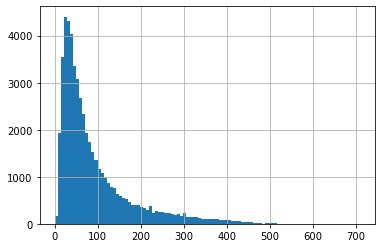

min wight - 0.10999999999989996, max wight - 708.62


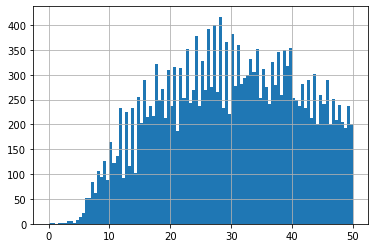

In [14]:
stats.wight.hist(bins=100)
plt.show()
print("min wight - {}, max wight - {}".format(min(wight), max(wight)))
stats.wight.hist(bins=100, range=[0, 50])
plt.show()


In [15]:
stats[stats.wight<5]

,name,index_in_file,classes,wight,hight,occluded,truncated
4629,000631.txt,2,Car,3.12,158.95,0,1.00
7938,001106.txt,8,Van,3.49,373.00,0,1.00
8238,001153.txt,2,Car,0.46,23.24,3,1.00
12373,001774.txt,5,DontCare,4.82,17.11,-1,-1.00
12945,001866.txt,0,Truck,2.03,374.00,0,1.00
15933,002294.txt,0,Truck,1.83,374.00,0,1.00
17434,002496.txt,6,DontCare,4.82,14.52,-1,-1.00
17568,002520.txt,1,Truck,4.33,375.00,0,1.00
18173,002609.txt,2,Person_sitting,3.86,134.60,0,0.97
20236,002901.txt,5,DontCare,4.82,8.06,-1,-1.00


In [16]:
# show_image(4569, 3)

In [17]:
print("{} - all objects; {} - all objects without DontCare, \
{} - without DontCare and truncated less then 70%".format(len(stats),
                                    len(stats[stats.classes != 'DontCare']),
                                    len(stats[(stats.classes != 'DontCare') & (stats.truncated < 0.7)])))

51865 - all objects; 40570 - all objects without DontCare, 38369 - without DontCare and truncated less then 70%


In [18]:
stats[stats.occluded == 0].head()

,name,index_in_file,classes,wight,hight,occluded,truncated
0,000000.txt,0,Pedestrian,98.33,164.92,0,0.0
1,000001.txt,0,Truck,30.34,32.85,0,0.0
2,000001.txt,1,Car,36.18,21.58,0,0.0
8,000002.txt,0,Misc,190.64,160.60,0,0.0
9,000002.txt,1,Car,42.68,33.26,0,0.0


In [19]:
# show_image(98, 1)

# for choose window's size

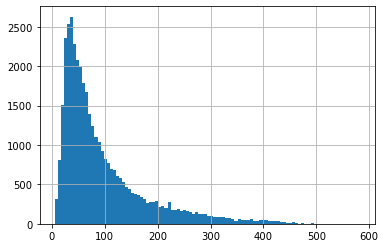

In [20]:
stats[(stats.classes != 'DontCare') & (stats.truncated < 0.7)].wight.hist(bins=100)
plt.show()

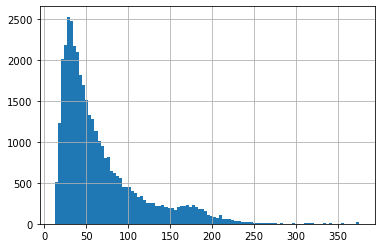

In [21]:
stats[(stats.classes != 'DontCare') & (stats.truncated < 0.7)].hight.hist(bins=100)
plt.show()